# Single Cell apoptosis

#### As decribed in Monier et al. 2015

In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet
from tyssue.config.json_parser import load_default

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel
from tyssue.solvers.sheet_vertex_solver import Solver as solver

#from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.stores import load_datasets

### Loading a dataset

Here it is a cylindrical hexagonal mesh.

In [6]:
!ls /home/guillaume/Dev/tyssue/src/tyssue/stores/

before_apoptosis.hf5  __init__.py  __pycache__	small_hexagonal.hf5


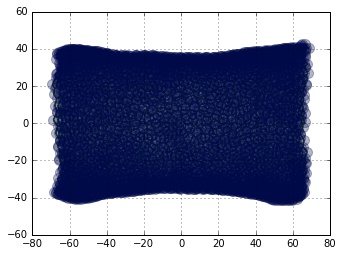

In [7]:
h5store = 'before_apoptosis.hf5'
datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])

sheet = Sheet('emin', datasets)
sheet.set_geom('sheet')
geom.update_all(sheet)

nondim_specs = load_default('dynamics', 'sheet')
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.set_model('sheet', dim_model_specs)

fig, ax = sheet_view(sheet, ['z', 'x'], **{'edge': {'width':1.}})

In [8]:
live_edges = sheet.upcast_face(sheet.face_df.is_alive)
dead_src = set(sheet.edge_df[live_edges==0].srce)

sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

In [9]:
settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


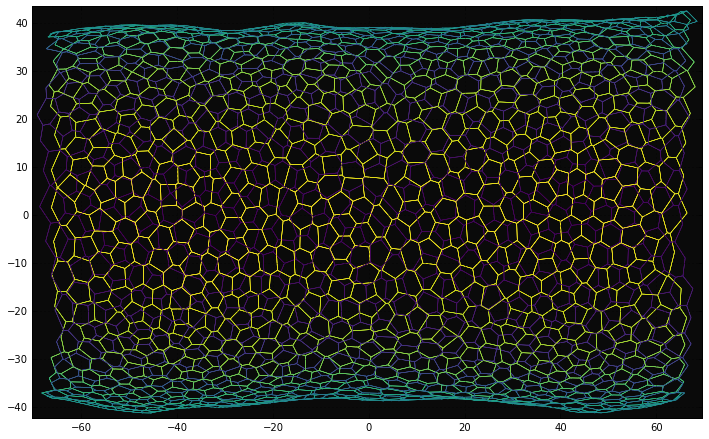

In [10]:
cmap = plt.cm.get_cmap('viridis')

depth = (sheet.upcast_srce(sheet.vert_df.y)
         #/ sheet.vert_df.y.max())
         - sheet.vert_df.y.min()) / sheet.vert_df.y.ptp()
depth_cmap = cmap(depth)
depth_cmap[:, -1] = depth.values

draw_specs = {
    'vert': {'visible': False},
    'edge': {'color': depth_cmap}
    }

fig, ax = sheet_view(sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(sheet.vert_df.z.min() - 1,
            sheet.vert_df.z.max() + 1)
ax.set_ylim(sheet.vert_df.x.min() - 1,
            sheet.vert_df.x.max() + 1)
ax.set_axis_bgcolor('#0a0a0a')
fig.set_size_inches((12, 12))

In [60]:
apoptotic_cell = 45

apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Indices of the apoptotic vertices: [ 143   65 2696 2697 1845]


In [11]:
class SheetEvents():
    
    
    def __init__(self, sheet, model, geom):
        self.sheet = sheet
        self.model = model
        self.geom = geom
        
    
    def get_events(self):
        events = {
            'face': {
                'shrink': self.shrink,
                'grow': self.grow,
                'contract': self.contract,
                'type1_at_shorter': self.type1_at_shorter,
                'type3': self.type3
                },
            'vert': {
                'ab_pull': self.ab_pull,
                }
            }
        return events

    def shrink(self, face, *args):
        factor = args[0]
        new_vol = self.sheet.specs['face']['prefered_vol'] * factor
        self.sheet.face_df.loc[face, 'prefered_vol'] = new_vol

    def grow(self, face, *args):
        return self.shrink(face, *args)
    
    def contract(self, face, *args):
        factor = args[0]
        new_contractility = self.sheet.specs['face']['contractility'] * factor
        self.sheet.face_df.loc[face, 'contractility'] = new_contractility
    
    def type1_at_shorter(self, face, *args):
        edges = self.sheet.edge_df['face'==face]
        shorter = edges.length.argmin()
        type1_transition(self.sheet, shorter)
        self.geom.update_all(self.sheet)
    
    def type3(self, face, *args):
        remove_face(sheet, face)
        self.geom.update_all(self.sheet)
    
    def ab_pull(self, vert, *args):
        factor = args[0]
        new_tension = self.sheet.specs['vert']['radial_tension'] * factor
        self.sheet.vert_df.loc[vert, 'radial_tension'] = new_tension

        

In [13]:
events = SheetEvents(sheet, model, geom).get_events()

In [14]:
events

{'face': {'contract': <bound method SheetEvents.contract of <__main__.SheetEvents object at 0x7f369c290e48>>,
  'grow': <bound method SheetEvents.grow of <__main__.SheetEvents object at 0x7f369c290e48>>,
  'shrink': <bound method SheetEvents.shrink of <__main__.SheetEvents object at 0x7f369c290e48>>,
  'type1_at_shorter': <bound method SheetEvents.type1_at_shorter of <__main__.SheetEvents object at 0x7f369c290e48>>,
  'type3': <bound method SheetEvents.type3 of <__main__.SheetEvents object at 0x7f369c290e48>>},
 'vert': {'ab_pull': <bound method SheetEvents.ab_pull of <__main__.SheetEvents object at 0x7f369c290e48>>}}

In [110]:
getattr(SheetBehaviors, 'shrink')

<function __main__.SheetBehaviors.shrink>

In [98]:
n_steps = 20

def shrink(stop, n_steps, logscale=True):
    if logscale:
        multiplier = np.logspace(0, stop, n_steps, base=2)
    else:
        multiplier = np.linspace(1, stop, n_steps)
    pref_vols = multiplier * sheet.specs['face']['prefered_vol']
    return pref_vols

def apoptosis_time_tables(sheet, apopto_cell,
                          start_t=0, n_steps):
    
    times = range(start_t, start_t + n_steps)
    cell_time_idx = pd.MultiIndex.from_tuples(
        [(t, apoptotic_cell) for t in times],
        names=['t', 'face'])
    time_tables['face'] = pd.DataFrame(index=cell_time_idx,
                                       columns=['prefered_vol',
                                                'contractility'])
    time_tables['face'].loc[:, 'prefered_vol'] =  shrink(-9, n_steps,
                                                         logscale=True)
    
    apoptotic_verts = sheet.edge_df['face' == apoptotic_cell]['srce']
    vert_time_idx = pd.MultiIndex.from_tuples(
        [(t, v) for t in times for v in apoptotic_verts],
         names=['t', 'vert'])
    time_tables['vert'] = pd.DataFrame(index=vert_time_idx,
                                       columns=['radial_tension',])

    rad_tensions = (np.linspace(0, 1, n_steps) *
                    sheet.specs['edge']['line_tension'])

    for v in apoptotic_verts:
        v_idx = pd.MultiIndex.from_tuples(
            [(t, v) for t in range(n_steps)], names=['t', 'vert'])
        time_tables['vert'].loc[v_idx, 'radial_tension'] = rad_tensions

    return time_tables


In [94]:

def make_mods(t, time_tables, sheet):
    '''At time step t, change the parameters as specified in time_tables'''
    
    for key, time_table in time_tables.items():
        mods = time_table.xs(t, level='t')
        for col in mods.columns:
            mod = mods[col].dropna()
            sheet.datasets[key].loc[mod.index, col] = mod


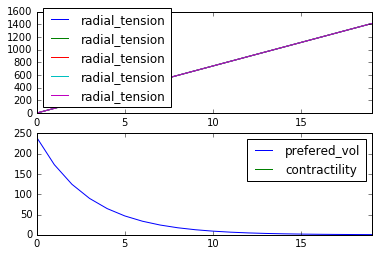

In [95]:
fig, axes = plt.subplots(2, 1)
for ax, (key, tt) in zip(axes, time_tables.items()):
    tt.groupby(level=key, ).plot(ax=ax, use_index=False)

In [96]:

for t in range(n_steps):
    make_mods(t, time_tables, sheet)
    res = solver.find_energy_min(sheet, geom, model, **settings)
    #fig, ax = sheet_view(sheet, ['z', 'x'])
    #plt.savefig('test_apopto_{:03d}.png'.format(i))
    #plt.close()
    


In [97]:
vp_view(sheet)

In [63]:
def solve_rosette():
    j = 0
    while len(apoptotic_edges) > 3:
        j += 1
        shorter = apoptotic_edges.length.argmin()
        type1_transition(sheet, shorter)
        geom.update_all(sheet)
        res = solver.find_energy_min(sheet, geom, 
                                     model, **settings)
        apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] ==
                                        apoptotic_cell]
        print(len(apoptotic_edges))
    
    #fig, ax = sheet_view(sheet, ['z', 'x'])
    #plt.savefig('test_apopto_{:03d}.png'.format(i+j))
    #plt.close()

4
3


In [64]:
remove_face(sheet, apoptotic_cell)
geom.update_all(sheet)
res = solver.find_energy_min(sheet, geom, model, **settings)

In [65]:
vp_view(sheet)

In [ ]:


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])
fig, ax = sheet_view(sheet, ['z', 'x'])